In [1]:
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Concatenate, Input, Lambda, Reshape
from keras.layers.embeddings import Embedding
from keras.utils.vis_utils import plot_model
from keras import backend as K

def rescale(x):
	input_value = x[0]
	embedding = x[1]
	## force cat_code 0 represent missing data
	mask = K.cast(input_value == 0, dtype=K.floatx())
	return embedding * mask + tf.multiply(embedding, input_value) * (1 - mask)

### Mixture of Categorical and Continuous (assume a hypothetical data)

In [3]:
categorical_vars = {"admitType": 4, "sex": 3, "race": 10}
continuous_dim = 2 # just for visualizing
embedding_size = 4

ins = []
input_cont = Input(shape=(continuous_dim,), name="continous")
input_cont_indct = Input(shape=(continuous_dim,), name="continous_indct")
ins.append(input_cont)
ins.append(input_cont_indct)
sub_models = []

for cat_var in categorical_vars.keys():
	_input = Input(shape=(1,), name=cat_var)
	ins.append(_input)
	k = categorical_vars[cat_var]
	_cat_embed = Embedding(k+1, embedding_size, input_length=1, name=cat_var + "_embedded")(_input)
	_cat_embed = Reshape(target_shape=(embedding_size,), name=cat_var + "_embedding_reshape")(_cat_embed)
	sub_models.append(_cat_embed)

scaled_embeds = []
for i in range(continuous_dim):
	_input_cont = Lambda(lambda l: l[:,i], name="input_cont_slice_" + str(i))(input_cont)
	_input_cont_indct = Lambda(lambda l: l[:,i], name="input_cont_indct_slice_" + str(i))(input_cont_indct)
	_cont_indct_embed = Embedding(2+1, embedding_size, input_length=1, name="continuous_indct_embedded_" + str(i))(_input_cont_indct)
	_cont_indct_embed = Reshape(target_shape=(embedding_size,), name="continuous_indct_embedding_reshape_" + str(i))(_cont_indct_embed)
	_scaled_embed = Lambda(rescale, name="cont_rescale_" + str(i))([_input_cont, _cont_indct_embed])
	scaled_embeds.append(_scaled_embed)

sub_cont = Concatenate(name="concat_scaled_embedding")(scaled_embeds)

sub_models.append(sub_cont)

x = Concatenate(name="concat_embedding")(sub_models)
for i in range(4):
	x = Dense(200, activation="relu", name="dense_" + str(i))(x)
outs = Dense(4, activation="softmax", name="dense_softmax")(x)
ehr_model = keras.Model(inputs=ins, outputs=outs)

2022-05-16 23:38:54.766102: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


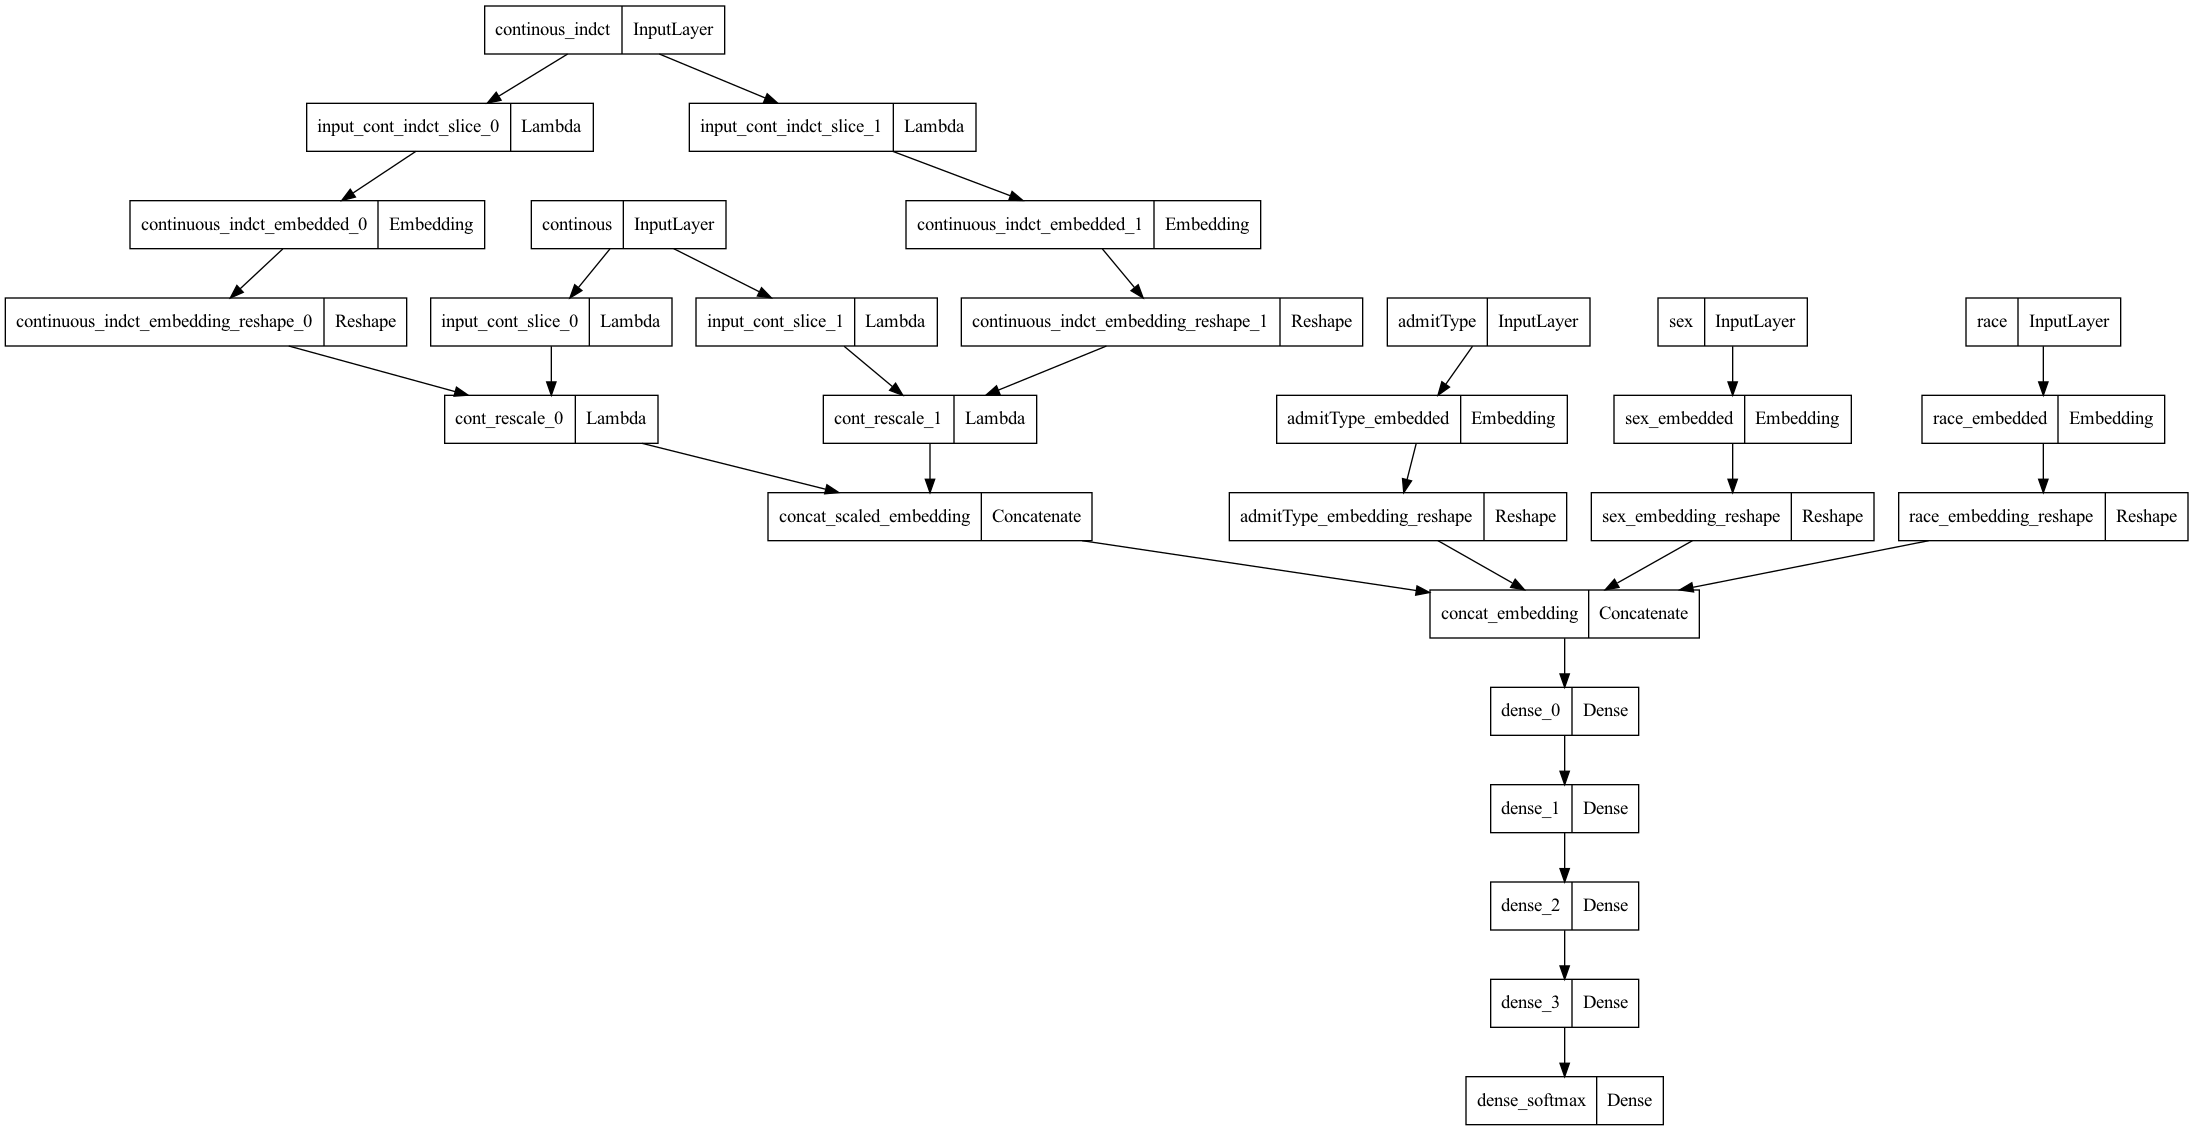

In [4]:
plot_model(ehr_model)